In [222]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import f_classif
import itertools

In [223]:
#penguins data
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)

#dropping columns: studyName, Individual ID, Date Egg, Sample Number
pdata = penguins.drop(['studyName', 'Individual ID', 'Date Egg', 'Region', 'Sample Number', 'Comments'], axis = 1)

#drop nan values
mydata = pdata.dropna()

#get rid of penguin with period for sex
data = mydata.drop(mydata.index[318])

#transforming cols that are not floats and ints
le = preprocessing.LabelEncoder()

#species 
data['Species'] = le.fit_transform(data['Species'])
#island
data['Island'] = le.fit_transform(data['Island'])
#stage
data['Stage'] = le.fit_transform(data['Stage'])
#clutch competition
data['Clutch Completion'] = le.fit_transform(data['Clutch Completion'])
#sex
data['Sex'] = le.fit_transform(data['Sex'])


In [224]:
#getting all possible combinations
names = list(data.columns)[1:]
combos = list(itertools.combinations(names, 3))


In [24]:
#using tree to select cols 
def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices
    """
    T = tree.DecisionTreeClassifier(max_depth = 5)
    return cross_val_score(T, x_train[cols], y_train, cv = 5).mean()  


def test_column_score(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices
    """
    cols = list(tupCol)
    T = tree.DecisionTreeClassifier(max_depth = 5)
    T.fit(x_train[cols], y_train)
    return T.score(x_test[cols], y_test)

In [31]:
#split into test and training data
train, test = train_test_split(data, test_size = 0.3)
train.shape, test.shape

x_train = train.drop(['Species'], axis = 1)
y_train = train['Species'].values

x_test = test.drop(['Species'], axis = 1)
y_test = test['Species'].values

In [33]:
#dict with cross value score of each combination 
D = {}
for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_score(cols)
    D[i] = x

In [34]:
#sort dict
L = list(D.items())
L.sort(key = lambda tup: tup[1], reverse = True)

#show 10 best scores
best = L[0:10]

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 29
('Island', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.97353
Test score is: 0.92857
---- 15
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.96889
Test score is: 0.9898
---- 16
('Island', 'Culmen Length (mm)', 'Flipper Length (mm)'), Score: 0.96
Test score is: 0.96939
---- 86
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.95594
Test score is: 0.96939
---- 18
('Island', 'Culmen Length (mm)', 'Sex'), Score: 0.95565
Test score is: 0.96939
---- 103
('Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.9514
Test score is: 0.92857
---- 91
('Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'), Score: 0.9513
Test score is: 0.95918
---- 85
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.95121
Test score is: 0.95918
---- 89
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 0.94705
Test score is: 0.9898
---- 19
('Island', 'Culmen Length (mm)', 'Delta 15 N (o/oo)'), Sco

In [35]:
#best one is island, culmen depth, culmen length
X_train = train[list(combos[15])]
X_test = test[list(combos[15])]

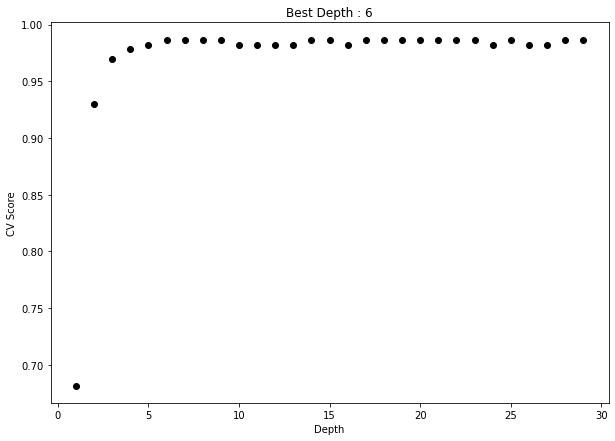

In [38]:
#test out best depth for tree
fig, ax = plt.subplots(1, figsize = (10, 7))

best_score = 0

for d in range(1,30):
    T = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best Depth : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

In [39]:
best_score

0.9867588932806324

In [40]:
#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
T.score(X_test, y_test)

0.9897959183673469

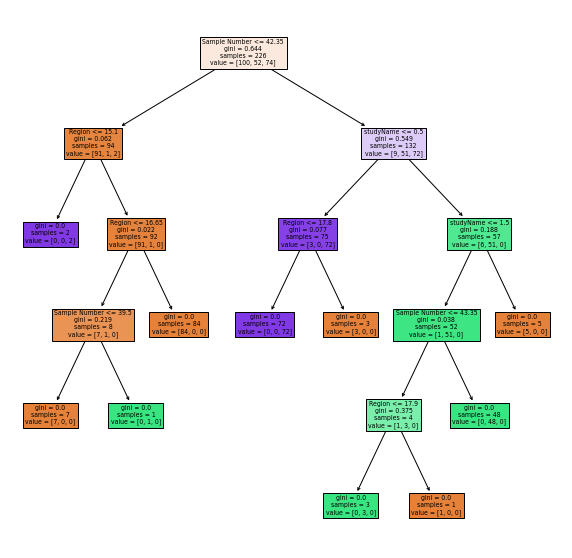

In [41]:
fig, ax = plt.subplots(1, figsize = (10, 10))
p = tree.plot_tree(T, 
                   filled = True, 
                   feature_names = penguins.drop(['Species'], axis = 1).columns)

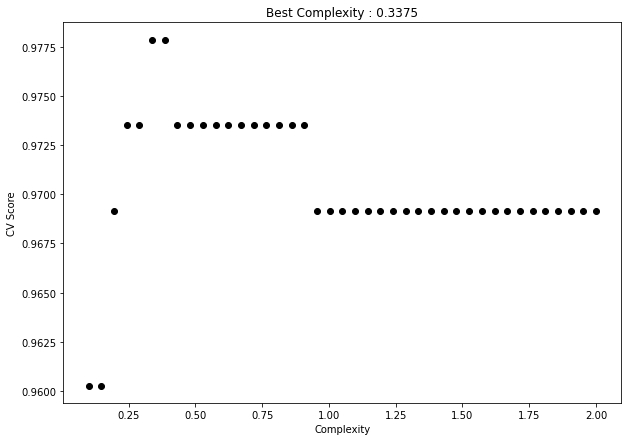

In [204]:
#test best complexity for logistic regresssion
fig, ax = plt.subplots(1, figsize = (10, 7))
lr_best_score = 0

#comp is short for complexity 
for comp in np.linspace(0.1, 2, 41):
    #range(1,30)
    logreg = LogisticRegression(max_iter = 1000, C = comp)
    cv_score = cross_val_score(logreg, X_train, y_train, cv=10).mean()
    ax.scatter(comp, cv_score, color = "black")
    
    if cv_score > lr_best_score:
        best_comp = comp
        lr_best_score = cv_score
    
    
l = ax.set(title = "Best Complexity : " + str(best_comp),
       xlabel = "Complexity", 
       ylabel = "CV Score")

In [205]:
#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9693877551020408

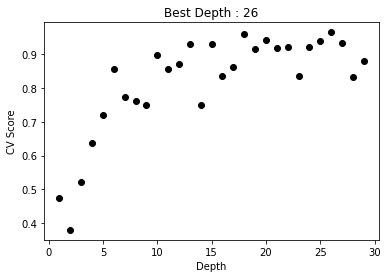

In [60]:
#MLP best depth
fig, ax = plt.subplots(1)
mlp_best_score = 0

# For 30 depths, find the highest score to find the best depth
for d in range(1,30):
    clf = MLPClassifier(hidden_layer_sizes=(d, d, d), max_iter=3000)
    cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > mlp_best_score:
        mlp_best_depth = d
        mlp_best_score = cv_score
        
l = ax.set(title = "Best Depth : " + str(mlp_best_depth),
xlabel = "Depth",
ylabel = "CV Score")

In [61]:
# Train an MLPClassifier at best complexity, and evaluate the model on the test set
clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9795918367346939

## Training Data with Logistic Regression 

In [206]:
def check_column_scorecv(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices using logistic regression
    """
    logreg = LogisticRegression(max_iter = 1000)
    return cross_val_score(logreg, x_train[cols], y_train, cv = 5).mean()

def test_column_scorecv(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices with logistic regreesion
    """
    cols = list(tupCol)
    logreg = LogisticRegression(max_iter = 1000)
    logreg.fit(x_train[cols], y_train)
    return logreg.score(x_test[cols], y_test)

In [207]:
E = {}
for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_scorecv(cols)
    E[i] = x

In [209]:
M = list(E.items())
M.sort(key = lambda tup: tup[1], reverse = True)

best = M

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 89
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 1.0
Test score is: 0.9898
---- 87
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'), Score: 0.99111
Test score is: 0.91837
---- 86
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.98676
Test score is: 0.96939
---- 88
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)'), Score: 0.98667
Test score is: 0.94898
---- 85
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.97778
Test score is: 0.95918
---- 93
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.97778
Test score is: 0.93878
---- 18
('Island', 'Culmen Length (mm)', 'Sex'), Score: 0.97343
Test score is: 0.96939
---- 94
('Culmen Length (mm)', 'Body Mass (g)', 'Sex'), Score: 0.96908
Test score is: 0.95918
---- 15
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.96899
Test score is: 0.9898
---- 99
('Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o

Test score is: 0.79592
---- 4
('Island', 'Stage', 'Body Mass (g)'), Score: 0.67266
Test score is: 0.80612
---- 30
('Island', 'Body Mass (g)', 'Sex'), Score: 0.67266
Test score is: 0.83673
---- 83
('Clutch Completion', 'Sex', 'Delta 13 C (o/oo)'), Score: 0.6685
Test score is: 0.66327
---- 62
('Stage', 'Sex', 'Delta 13 C (o/oo)'), Score: 0.66831
Test score is: 0.66327
---- 41
('Stage', 'Clutch Completion', 'Delta 15 N (o/oo)'), Score: 0.65952
Test score is: 0.62245
---- 82
('Clutch Completion', 'Sex', 'Delta 15 N (o/oo)'), Score: 0.64599
Test score is: 0.62245
---- 61
('Stage', 'Sex', 'Delta 15 N (o/oo)'), Score: 0.64135
Test score is: 0.62245
---- 0
('Island', 'Stage', 'Clutch Completion'), Score: 0.62831
Test score is: 0.7449
---- 12
('Island', 'Clutch Completion', 'Sex'), Score: 0.62831
Test score is: 0.7449
---- 39
('Stage', 'Clutch Completion', 'Body Mass (g)'), Score: 0.62812
Test score is: 0.73469
---- 5
('Island', 'Stage', 'Sex'), Score: 0.60155
Test score is: 0.7449
---- 58
('St

In [211]:
#testing models 
X_train = train[list(combos[89])]
X_test = test[list(combos[89])]

In [219]:
def tree_best_depth(): 
    fig, ax = plt.subplots(1, figsize = (10, 7))

    best_score = 0

    for d in range(1,30):
        T = tree.DecisionTreeClassifier(max_depth = d)
        cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
        ax.scatter(d, cv_score, color = "black")

        if cv_score > best_score:
            best_depth = d
            best_score = cv_score

    l = ax.set(title = "Best Depth : " + str(best_depth),
           xlabel = "Depth", 
           ylabel = "CV Score")
    return best_depth, best_score

def best_complex():
    #test best complexity for logistic regresssion
    fig, ax = plt.subplots(1, figsize = (10, 7))
    lr_best_score = 0

    #comp is short for complexity 
    for comp in np.linspace(0.1, 2, 41):
        #range(1,30)
        logreg = LogisticRegression(max_iter = 1000, C = comp)
        cv_score = cross_val_score(logreg, X_train, y_train, cv=10).mean()
        ax.scatter(comp, cv_score, color = "black")

        if cv_score > lr_best_score:
            best_comp = comp
            lr_best_score = cv_score


    l = ax.set(title = "Best Complexity : " + str(best_comp),
           xlabel = "Complexity", 
           ylabel = "CV Score")
    
    return best_comp, best_score

def mlp_depth():
    fig, ax = plt.subplots(1)
    mlp_best_score = 0

    # For 30 depths, find the highest score to find the best depth
    for d in range(1,30):
        clf = MLPClassifier(hidden_layer_sizes=(d, d, d), max_iter=3000)
        cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
        ax.scatter(d, cv_score, color = "black")
        if cv_score > mlp_best_score:
            mlp_best_depth = d
            mlp_best_score = cv_score

    l = ax.set(title = "Best Depth : " + str(mlp_best_depth),
    xlabel = "Depth",
    ylabel = "CV Score")
    
    return mlp_best_depth, mlp_best_score

0.9737154150197629

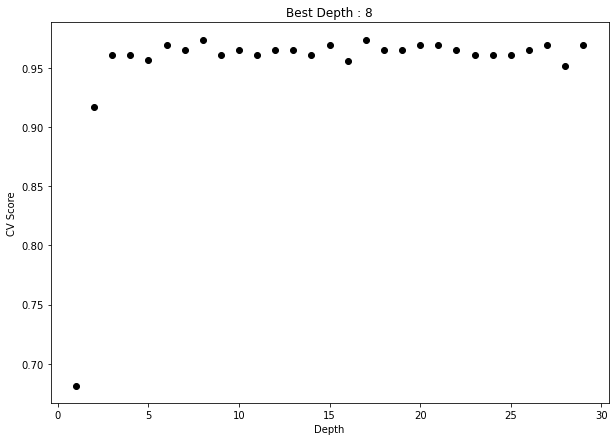

In [213]:
best_depth, best_score = tree_best_depth()
print(best_score)

In [214]:
#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
T.score(X_test, y_test)

0.9897959183673469

0.9737154150197629

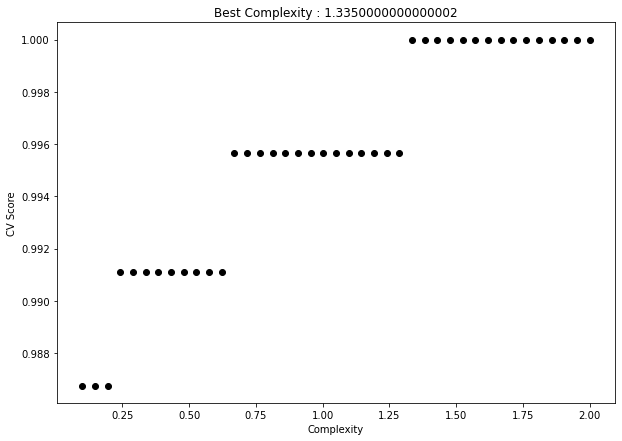

In [217]:
best_comp, best_score = best_complex()
best_score

In [218]:
#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9897959183673469

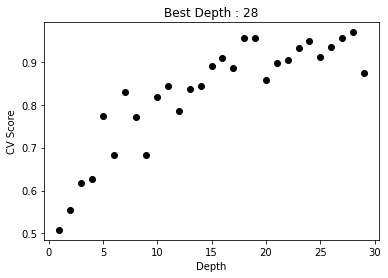

In [220]:
mlp_best_score, mlp_best_depth = mlp_depth()

In [221]:
# Train an MLPClassifier at best complexity, and evaluate the model on the test set
clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9693877551020408

Lauren's way

In [228]:
threshold = 5 # the number of most relevant features
high_score_features = []
feature_scores = f_classif(x_train, y_train)[0]
for score, f_name in sorted(zip(feature_scores, x_train.columns), reverse=True)[:threshold]:
      print(f_name, score)
      high_score_features.append(f_name)

Stage nan
Flipper Length (mm) 365.1069077264567
Culmen Length (mm) 281.2614644972567
Culmen Depth (mm) 233.86469890724268
Body Mass (g) 214.08580404981282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [229]:
X_train = train[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']]
X_test = test[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']]

training score: 0.9733201581027668


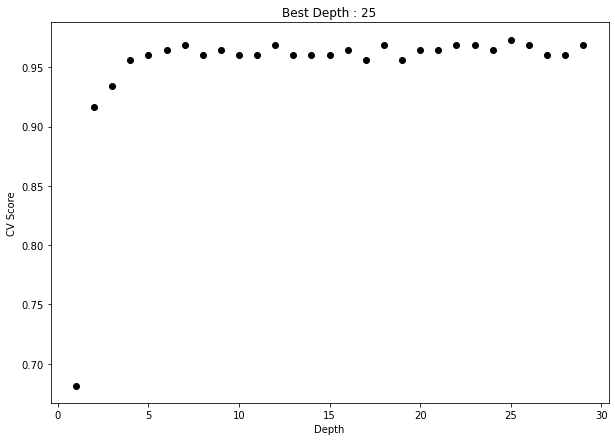

In [231]:
#tree
best_depth, best_score = tree_best_depth()
print("training score: " + str(best_score))

#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
tree_score = T.score(X_test, y_test)

In [232]:
tree_score

0.9897959183673469

training score: 0.9733201581027668


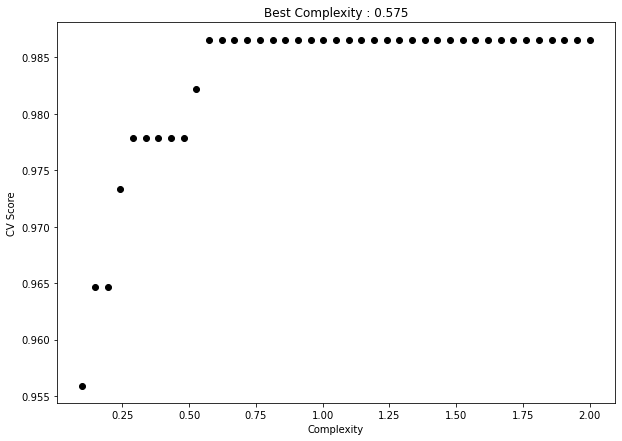

In [233]:
best_comp, best_score = best_complex()
print("training score: " + str(best_score))

#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

In [234]:
lr_score

0.9897959183673469

training score: 18


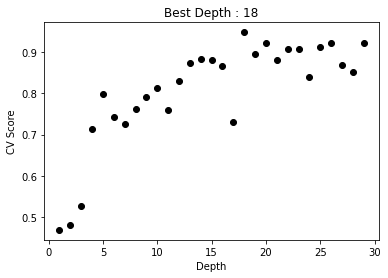

In [235]:
mlp_best_score, mlp_best_depth = mlp_depth()
print("training score: " + str(mlp_best_score))

clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
mlp_score = clf.score(X_test, y_test)

In [236]:
mlp_score

0.9387755102040817

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Female Penguins')

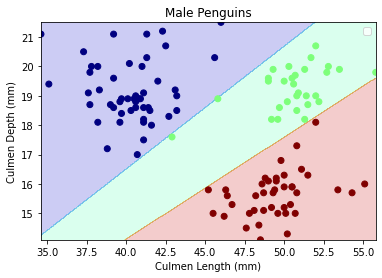

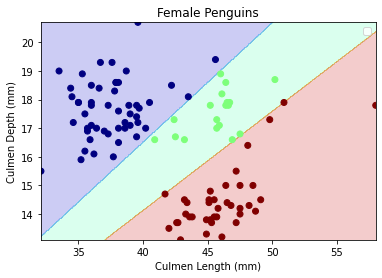

In [249]:
def plot_regions(c, X, y):
    '''
    function used to plot regions 
    borrowed from the live lecture's code
    '''
        
    # for convenience, give names to the two 
    # columns of the data
    x0 = X['Culmen Length (mm)']
    x1 = X['Culmen Depth (mm)']
    
    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    XX = xx.ravel()
    YY = yy.ravel()
    
    XY = np.c_[XX, YY]

    p = c.predict(XY)
    p = p.reshape(xx.shape)
    
    # create the plot
    fig, ax = plt.subplots(1)
    
    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
    
    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
    ax.set(xlabel = "Culmen Length (mm)", 
           ylabel = "Culmen Depth (mm)")


    
# Fit the model with dropped Sex column, so that it can have 2 columns for plot regions

clf.fit(X_train.drop(['Sex'], axis=1), y_train)

# Separate the males and females, drop the sex column, predict the y's and plot
X_male = X_train.loc[X_train['Sex'] == 1]
X_male = X_male.drop(['Sex'], axis=1)
y_male = clf.predict(X_male)

X_female = X_train.loc[X_train['Sex'] == 0]
X_female = X_female.drop(['Sex'], axis=1)
y_female = clf.predict(X_female)

plot_regions(clf, X_male, y_male) 
plt.title("Male Penguins")

plot_regions(clf, X_female, y_female)
plt.title("Female Penguins")

